In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import wandb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

# Initialize wandb
wandb.init(project="binary-classifier", config={
    "img_width": 128,
    "img_height": 128,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "architecture": "VGG16",
})


# Configuration
config = wandb.config
data_dir = r'./Data/train'
test_dir = r'./Data/test1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dnicho26 (dnicho26-university-of-north-carolina-at-charlotte). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.5


wandb: Run data is saved locally in /opt/notebooks/Applied-AI-Midterm/wandb/run-20241026_224717-0b4reije
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run curious-bush-3


wandb: ⭐️ View project at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/binary-classifier


wandb: 🚀 View run at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/binary-classifier/runs/0b4reije


True
Tesla P100-PCIE-16GB


In [2]:
# Custom Dataset to handle your directory structure
class CustomImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        
        label = 0 if 'cat' in img_path else 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
# Gathering all image paths
all_images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
train_size = int(0.8 * len(all_images))
valid_size = len(all_images) - train_size

# Splitting the dataset into training and validation sets
train_images, valid_images = torch.utils.data.random_split(all_images, [train_size, valid_size])

# Data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Creating datasets and loaders
train_dataset = CustomImageDataset(train_images, transform=data_transforms['train'])
valid_dataset = CustomImageDataset(valid_images, transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9333333966732026].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


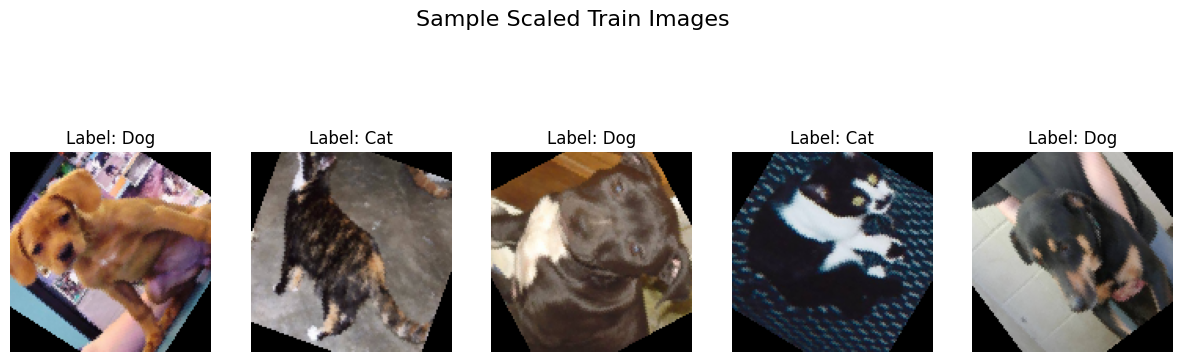

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1333333625793457..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10980393218994139..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


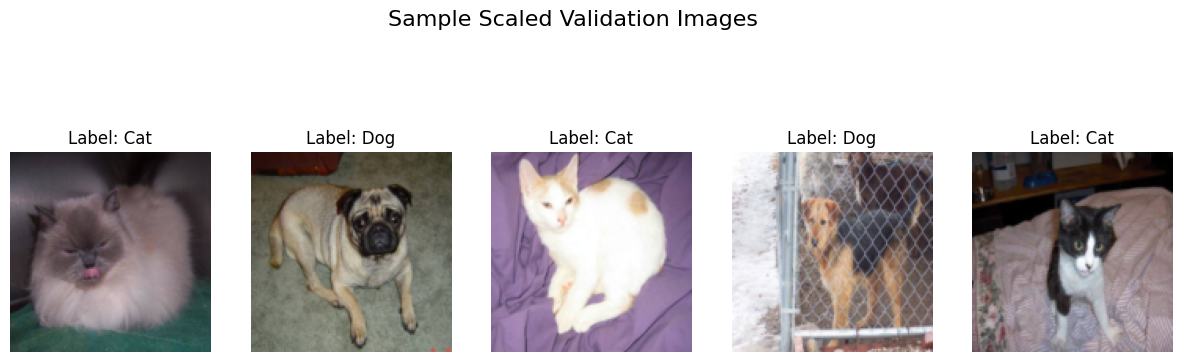

In [4]:
import matplotlib.pyplot as plt

def show_images_from_loader(loader, title):
    # Fetch a batch of images
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axs):
        ax.imshow(images[i] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        ax.set_title(f'Label: {"Cat" if labels[i] == 0 else "Dog"}')
        ax.axis('off')

    plt.show()

# Display some train images
show_images_from_loader(train_loader, "Sample Scaled Train Images")

# Display some validation images
show_images_from_loader(valid_loader, "Sample Scaled Validation Images")

In [5]:
# Load pretrained VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Modify the output layer to match the number of classes

# Freeze layers except the last few
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Define loss function and optimizer
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=[0 if 'cat' in img else 1 for img in all_images])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import os

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_val_loss = float('inf')

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.best_val_loss = val_loss


In [7]:
# Training loop with early stopping
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, patience=5, model_path='best_model.pth'):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Log training metrics to wandb
        wandb.log({"train_loss": epoch_loss, "train_accuracy": epoch_acc})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)
        
        # Log validation metrics to wandb
        wandb.log({"val_loss": val_loss, "val_accuracy": val_acc})

        print(f'Epoch {epoch}/{epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Early stopping
        early_stopping(val_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

# Train the model
train_model(model, criterion, optimizer, train_loader, valid_loader, config.epochs, patience=10, model_path='best_vgg16_model.pth')

# Finish the wandb run
wandb.finish()

Epoch 0/99, Loss: 0.5299, Acc: 0.8523, Val Loss: 0.0974, Val Acc: 0.9706
Validation loss decreased (inf --> 0.097436).  Saving model ...


Epoch 1/99, Loss: 0.4126, Acc: 0.8649, Val Loss: 0.1355, Val Acc: 0.9516
EarlyStopping counter: 1 out of 10


Epoch 2/99, Loss: 0.3354, Acc: 0.8789, Val Loss: 0.1319, Val Acc: 0.9676
EarlyStopping counter: 2 out of 10


Epoch 3/99, Loss: 0.3623, Acc: 0.8732, Val Loss: 0.0973, Val Acc: 0.9686
Validation loss decreased (0.097436 --> 0.097324).  Saving model ...


Epoch 4/99, Loss: 0.3273, Acc: 0.8841, Val Loss: 0.1325, Val Acc: 0.9668
EarlyStopping counter: 1 out of 10


Epoch 5/99, Loss: 0.3652, Acc: 0.8800, Val Loss: 0.0839, Val Acc: 0.9682
Validation loss decreased (0.097324 --> 0.083902).  Saving model ...


Epoch 6/99, Loss: 0.3221, Acc: 0.8860, Val Loss: 0.0956, Val Acc: 0.9652
EarlyStopping counter: 1 out of 10


Epoch 7/99, Loss: 0.3008, Acc: 0.8891, Val Loss: 0.0910, Val Acc: 0.9684
EarlyStopping counter: 2 out of 10


Epoch 8/99, Loss: 0.3046, Acc: 0.8890, Val Loss: 0.1250, Val Acc: 0.9688
EarlyStopping counter: 3 out of 10


Epoch 9/99, Loss: 0.3268, Acc: 0.8829, Val Loss: 0.0909, Val Acc: 0.9684
EarlyStopping counter: 4 out of 10


Epoch 10/99, Loss: 0.3228, Acc: 0.8865, Val Loss: 0.1246, Val Acc: 0.9668
EarlyStopping counter: 5 out of 10


Epoch 11/99, Loss: 0.3239, Acc: 0.8875, Val Loss: 0.1136, Val Acc: 0.9692
EarlyStopping counter: 6 out of 10


Epoch 12/99, Loss: 0.3213, Acc: 0.8900, Val Loss: 0.0985, Val Acc: 0.9660
EarlyStopping counter: 7 out of 10


Epoch 13/99, Loss: 0.3519, Acc: 0.8851, Val Loss: 0.0984, Val Acc: 0.9662
EarlyStopping counter: 8 out of 10


Epoch 14/99, Loss: 0.3407, Acc: 0.8906, Val Loss: 0.0985, Val Acc: 0.9666
EarlyStopping counter: 9 out of 10


Epoch 15/99, Loss: 0.3542, Acc: 0.8916, Val Loss: 0.0960, Val Acc: 0.9666
EarlyStopping counter: 10 out of 10
Early stopping triggered


wandb:                                                                                


wandb: 
wandb: Run history:
wandb: train_accuracy ▁▃▆▅▇▆▇██▆▇▇█▇██
wandb:     train_loss █▄▂▃▂▃▂▁▁▂▂▂▂▃▂▃
wandb:   val_accuracy █▁▇▇▇▇▆▇▇▇▇▇▆▆▇▇
wandb:       val_loss ▃██▃█▁▃▂▇▂▇▅▃▃▃▃
wandb: 
wandb: Run summary:
wandb: train_accuracy 0.89155
wandb:     train_loss 0.35418
wandb:   val_accuracy 0.9666
wandb:       val_loss 0.096
wandb: 


wandb: 🚀 View run curious-bush-3 at: https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/binary-classifier/runs/0b4reije
wandb: ⭐️ View project at: https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/binary-classifier
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20241026_224717-0b4reije/logs
